# TalkingData: Fraudulent Click Prediction
In this notebook, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.

The analysis is divided into the following sections:

Understanding the business problem
Understanding and exploring the data
Feature engineering: Creating new features
Model building and evaluation: AdaBoost
Modelling building and evaluation: Gradient Boosting
Modelling building and evaluation: XGBoost

# Understanding the Business Problem
TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released the problem on Kaggle here..

# Understanding and Exploring the Data
The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded
Let's try finding some useful trends in the data.

In [1]:
#read the data
#describe data
#find the relation
#explore the univariant analysis
#Feature Enginnering
#modelling the data(train test split)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv(r'C:\Users\vivek\Downloads/train_sample.csv')

In [4]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
#data missing value
df.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [6]:
attributed_time=df['attributed_time'].mode

In [7]:
df['attributed_time'].fillna(value=attributed_time,inplace=True)

In [8]:
df.isnull().sum()

ip                 0
app                0
device             0
os                 0
channel            0
click_time         0
attributed_time    0
is_attributed      0
dtype: int64

<AxesSubplot:>

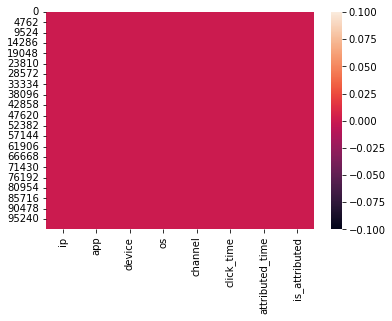

In [9]:
sns.heatmap(df.isnull())

<AxesSubplot:>

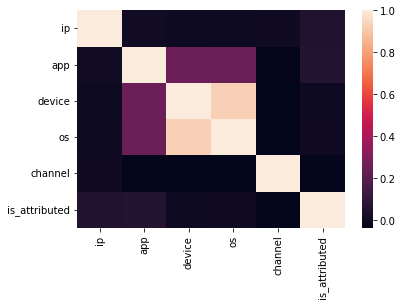

In [10]:
sns.heatmap(df.corr())

In [11]:
df.corr()

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.010400,-0.001499,-0.000470,0.007563,0.054955
app,0.010400,1.000000,0.248376,0.247160,-0.028238,0.064426
device,-0.001499,0.248376,1.000000,0.924456,-0.035398,-0.000695
os,-0.000470,0.247160,0.924456,1.000000,-0.033175,0.006183
channel,0.007563,-0.028238,-0.035398,-0.033175,1.000000,-0.023336
is_attributed,0.054955,0.064426,-0.000695,0.006183,-0.023336,1.000000


In [12]:
df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [13]:
df.is_attributed.value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [14]:
df.click_time.value_counts()

2017-11-08 12:01:02    7
2017-11-07 05:00:11    6
2017-11-09 14:46:23    6
2017-11-07 04:36:16    6
2017-11-08 13:32:05    6
                      ..
2017-11-07 08:31:55    1
2017-11-08 23:35:15    1
2017-11-08 10:01:33    1
2017-11-09 11:01:52    1
2017-11-09 13:25:41    1
Name: click_time, Length: 80350, dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  100000 non-null  object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [16]:
df.shape

(100000, 8)

In [17]:
from sklearn.preprocessing import OrdinalEncoder

In [18]:
Oc=OrdinalEncoder()

In [19]:
Oc

OrdinalEncoder()

In [20]:
df['click_time1']=Oc.fit_transform((df[['click_time']]))

In [21]:
df[['click_time','click_time1']].head(100000)

,click_time,click_time1
0,2017-11-07 09:30:38,17415.0
1,2017-11-07 13:40:27,23123.0
2,2017-11-07 18:05:24,27844.0
3,2017-11-07 04:58:08,11508.0
4,2017-11-09 09:00:09,70545.0
...,...,...
99995,2017-11-09 13:25:41,76690.0
99996,2017-11-07 11:25:43,20091.0
99997,2017-11-08 11:38:42,46757.0
99998,2017-11-08 17:55:21,54934.0


In [22]:
#df.dropna(axis='columns',inplace=True)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
#X=df.drop(['is_attributed','click_time'],axis=1)

In [27]:
X=df.iloc[:,0:5]

In [28]:
X

,ip,app,device,os,channel
0,87540,12,1,13,497
1,105560,25,1,17,259
2,101424,12,1,19,212
3,94584,13,1,13,477
4,68413,12,1,1,178
...,...,...,...,...,...
99995,124883,11,1,19,122
99996,85150,9,1,13,244
99997,18839,3,1,13,19
99998,114276,15,1,12,245


In [29]:
y=df.is_attributed

In [30]:
y

0        0
1        0
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: is_attributed, Length: 100000, dtype: int64

In [32]:
from sklearn.preprocessing import StandardScaler


In [33]:
scaler=StandardScaler()

In [35]:
scaled=scaler.fit_transform(X)

In [36]:
scaled

array([[-0.05320926, -0.00320451, -0.07999204, -0.17550552,  1.75887457],
       [ 0.20482678,  0.86685974, -0.07999204, -0.10400399, -0.07579546],
       [ 0.14560164, -0.00320451, -0.07999204, -0.06825322, -0.43810425],
       ...,
       [-1.03696811, -0.60555669, -0.07999204, -0.17550552, -1.92588288],
       [ 0.3296349 ,  0.19757955, -0.07999204, -0.1933809 , -0.18371723],
       [ 0.40227734,  0.13065153, -0.07999204, -0.13975475,  1.0188396 ]])

In [37]:
X_train,X_test,y_train,y_test=train_test_split(Xscaled,y,test_size=0.3,random_state=101)

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
treemodel=DecisionTreeClassifier(max_depth=2)

In [40]:
treemodel.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

[Text(0.5, 0.8333333333333334, 'X[2] <= -0.082\ngini = 0.005\nsamples = 70000\nvalue = [69842, 158]'),
 Text(0.25, 0.5, 'X[0] <= 2.015\ngini = 0.176\nsamples = 370\nvalue = [334, 36]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.136\nsamples = 327\nvalue = [303, 24]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.402\nsamples = 43\nvalue = [31, 12]'),
 Text(0.75, 0.5, 'X[1] <= 1.101\ngini = 0.003\nsamples = 69630\nvalue = [69508, 122]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.002\nsamples = 67671\nvalue = [67612, 59]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.062\nsamples = 1959\nvalue = [1896, 63]')]

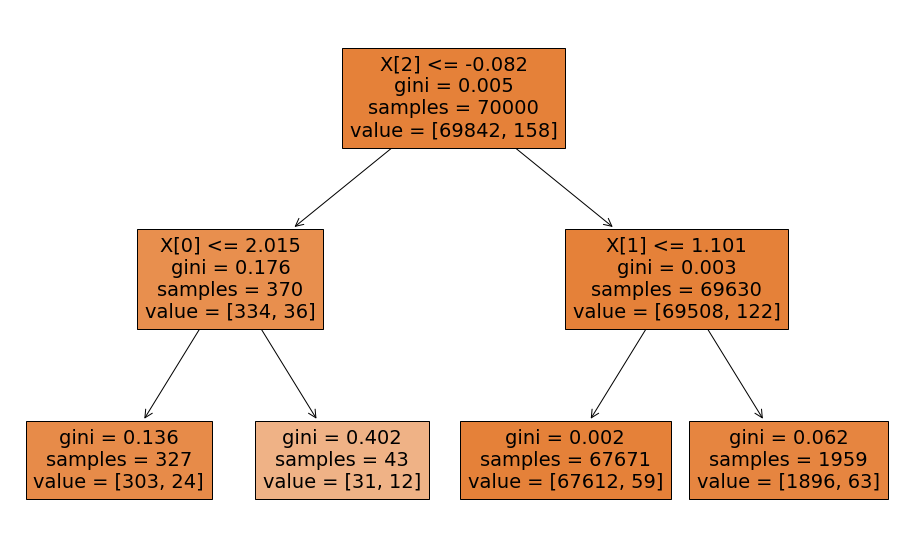

In [41]:
from sklearn import tree
plt.figure(figsize=(16,10))
tree.plot_tree(treemodel,filled=True)

In [42]:
y_pred=treemodel.predict(X_test)

In [43]:
from sklearn.metrics import classification_report,accuracy_score

In [44]:
accuracy_score(y_pred,y_test)

0.9977